## Import all the required libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay


---

The goal of the analysis is to identify patterns, trends, and factors contributing to crime in LA. Depending on the specific question we want to answer, our analysis might focus on predicting the occurrence of crimes, identifying crime hotspots, or understanding the factors that influence crime rates.

### Step 1: Read the `Crime_Data_from_2020_to_Present_20240611.csv.csv` data from the `static\data\` folder into a Pandas DataFrame.

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame

crime_df = pd.read_csv(
    Path("static\data\Crime_Data_from_2020_to_Present_20240611.csv")            

)

# Review the DataFrame
crime_df.head()
# Review the DataFrame


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,3/1/2020 0:00,3/1/2020 0:00,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,2/9/2020 0:00,2/8/2020 0:00,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 0:00,11/4/2020 0:00,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,5/10/2023 0:00,3/10/2020 0:00,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,8/18/2022 0:00,8/17/2020 0:00,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


#### Creating categorical variable list

In [3]:
#Generate our categorical variable list
crime_cat = crime_df.dtypes[crime_df.dtypes == "object"].index.tolist()

In [4]:
#Check the number of unique columns in each column
crime_df[crime_cat].nunique()

Date Rptd         1609
DATE OCC          1609
AREA NAME           21
Crm Cd Desc        139
Mocodes         306996
Vict Sex             5
Vict Descent        20
Premis Desc        306
Weapon Desc         79
Status               6
Status Desc          6
LOCATION         65757
Cross Street     10181
dtype: int64

## STEP 2: Data Cleansing - The data is cleaned, normalized, and standardized prior to modeling 

### To handle the huge crime data and we categorized into the handful crimes 

In [5]:

# Read the CSV file from the Resources folder into a Pandas DataFrame

crimebin_df = pd.read_csv(
    Path("static\data\crime_bins.csv")            

)

# Review the DataFrame
crimebin_df.head()
# Review the DataFrame

,Crm Cd Desc,CRIMEBIN
0,ARSON,VANDALISM
1,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,VIOLENT
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",VIOLENT
3,ATTEMPTED ROBBERY,ROBBERY
4,BATTERY - SIMPLE ASSAULT,VIOLENT


In [6]:
# Merge the actual data with the crime bins.
merged_df = pd.merge(crime_df, crimebin_df, on='Crm Cd Desc', how='inner')
merged_df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,CRIMEBIN
0,190326475,3/1/2020 0:00,3/1/2020 0:00,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506,VEHICLE
1,221008844,5/6/2022 0:00,11/1/2020 0:00,130,10,West Valley,1029,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,VALJEAN ST,VANOWEN AV,34.1939,-118.4859,VEHICLE
2,200412582,9/9/2020 0:00,9/9/2020 0:00,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130,VEHICLE
3,201810154,4/26/2020 0:00,4/22/2020 0:00,1900,18,Southeast,1802,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,90TH,WALL,33.9547,-118.2717,VEHICLE
4,231510293,5/27/2023 0:00,11/24/2020 0:00,200,15,N Hollywood,1504,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,7500 LAUREL CANYON BL,NaN,34.2071,-118.3965,VEHICLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947678,231008207,4/20/2023 0:00,11/1/2022 0:00,1900,10,West Valley,1077,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,Adult Arrest,445.0,NaN,NaN,NaN,17300 VENTURA BL,NaN,34.1608,-118.5098,theft
947679,231507120,3/16/2023 0:00,3/12/2023 0:00,2015,15,N Hollywood,1533,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,Invest Cont,445.0,NaN,NaN,NaN,6000 LAUREL CANYON BL,NaN,34.1794,-118.3965,theft
947680,241708301,4/13/2024 0:00,10/30/2023 0:00,2130,17,Devonshire,1782,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,Invest Cont,445.0,NaN,NaN,NaN,8800 CORBIN AV,NaN,34.2302,-118.5623,theft
947681,241707918,4/2/2024 0:00,1/11/2024 0:00,1959,17,Devonshire,1782,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,Invest Cont,445.0,NaN,NaN,NaN,8800 CORBIN AV,NaN,34.2302,-118.5623,theft


In [7]:
# Cleanse the time related data and add day of the week feature for improve the accuracy
merged_df['DATE OCC'] = pd.to_datetime(merged_df['DATE OCC'])
merged_df['year'] = merged_df['DATE OCC'].dt.year
merged_df['month'] = merged_df['DATE OCC'].dt.month
merged_df['day_of_week'] = merged_df['DATE OCC'].dt.day_name()
merged_df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,CRIMEBIN,year,month,day_of_week
0,190326475,3/1/2020 0:00,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506,VEHICLE,2020,3,Sunday
1,221008844,5/6/2022 0:00,2020-11-01,130,10,West Valley,1029,1,510,VEHICLE - STOLEN,...,NaN,NaN,VALJEAN ST,VANOWEN AV,34.1939,-118.4859,VEHICLE,2020,11,Sunday
2,200412582,9/9/2020 0:00,2020-09-09,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130,VEHICLE,2020,9,Wednesday
3,201810154,4/26/2020 0:00,2020-04-22,1900,18,Southeast,1802,1,510,VEHICLE - STOLEN,...,NaN,NaN,90TH,WALL,33.9547,-118.2717,VEHICLE,2020,4,Wednesday
4,231510293,5/27/2023 0:00,2020-11-24,200,15,N Hollywood,1504,1,510,VEHICLE - STOLEN,...,NaN,NaN,7500 LAUREL CANYON BL,NaN,34.2071,-118.3965,VEHICLE,2020,11,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947678,231008207,4/20/2023 0:00,2022-11-01,1900,10,West Valley,1077,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,NaN,NaN,17300 VENTURA BL,NaN,34.1608,-118.5098,theft,2022,11,Tuesday
947679,231507120,3/16/2023 0:00,2023-03-12,2015,15,N Hollywood,1533,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,NaN,NaN,6000 LAUREL CANYON BL,NaN,34.1794,-118.3965,theft,2023,3,Sunday
947680,241708301,4/13/2024 0:00,2023-10-30,2130,17,Devonshire,1782,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,NaN,NaN,8800 CORBIN AV,NaN,34.2302,-118.5623,theft,2023,10,Monday
947681,241707918,4/2/2024 0:00,2024-01-11,1959,17,Devonshire,1782,1,445,DISHONEST EMPLOYEE ATTEMPTED THEFT,...,NaN,NaN,8800 CORBIN AV,NaN,34.2302,-118.5623,theft,2024,1,Thursday


### Step 3: Create the labels set (`y`)  from the “crime” column, and then create the features (`X`) DataFrame from the remaining columns.

Features are input variable that we will use to predict the target variable.  For Crime analysis, potential features could be 
1. Temporal Features: Date, time,day of the week,month or season and year of crime
2. Spatial Features: Location coordinates, District, Zipcode ( we need to add county and zipcode)
3. Crime Characteristic :  Type of crime (Crm cd column),Description of the crime (Crm cd Desc),Crime Severity ( we do not have this)
4. socio economic and Demographic features :  like population Density,Median household income, unemployment rate, education level, age distribution, ethnicity distribution  - We do not have this information.

Target is dependent Variable  : This is what we want to predict or understand.  potential targets.
1. Crime Occurence (whether a crime will occur at a given time and location (binary Classification))
2. Crime Type ( the type of crime that will occur (multi-class classification))
3. Crime Severity ( the severity level of Crime (regression or classification))




In [8]:
crime_req_df1 = merged_df[['year','month','day_of_week','TIME OCC','Vict Age','Vict Sex','AREA','CRIMEBIN']]
crime_req_df = crime_req_df1[(crime_req_df1['Vict Age'] > 10 )  ]

In [9]:
col_encode = ['day_of_week','Vict Sex']
crime_req_df = pd.get_dummies(crime_req_df, columns=col_encode)

In [10]:
# crime_req_df = merged_df[['year','month','TIME OCC','AREA','CRIMEBIN']]
X = crime_req_df.drop(columns=['CRIMEBIN'])
y = crime_req_df['CRIMEBIN']
crime_req_df

,year,month,TIME OCC,Vict Age,AREA,CRIMEBIN,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Vict Sex_F,Vict Sex_H,Vict Sex_M,Vict Sex_X
474,2020,7,1930,64,12,VEHICLE,False,False,False,True,False,False,False,False,False,True,False
824,2020,5,1800,19,3,VEHICLE,False,False,True,False,False,False,False,False,False,False,True
1154,2020,10,2150,17,11,VEHICLE,False,False,False,True,False,False,False,False,False,True,False
1770,2020,10,2300,51,13,VEHICLE,True,False,False,False,False,False,False,False,False,False,False
1784,2020,5,40,20,18,VEHICLE,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947655,2023,2,1700,60,10,OTHER,False,False,False,False,False,False,True,False,False,True,False
947673,2023,11,1200,15,12,OTHER,True,False,False,False,False,False,False,True,False,False,False
947677,2024,3,1,29,20,OTHER,False,False,False,True,False,False,False,True,False,False,False
947679,2023,3,2015,60,15,theft,False,False,False,True,False,False,False,False,False,True,False


In [11]:
#Split the data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [12]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.35926944941065636
Precision: 0.30930365166736457
Recall: 0.35926944941065636
F1 Score: 0.3203580702676809

Classification Report:
               precision    recall  f1-score   support

    BURGLARY       0.23      0.14      0.18     39764
       CHILD       0.40      0.29      0.34      2098
    Homicide       0.08      0.01      0.02       584
       OTHER       0.10      0.02      0.03      4152
     ROBBERY       0.10      0.03      0.04     11683
         SEX       0.24      0.08      0.12      8796
   VANDALISM       0.14      0.06      0.08     29326
     VEHICLE       0.04      0.00      0.01      1877
     VIOLENT       0.39      0.55      0.46     90090
       fraud       0.11      0.02      0.03      8483
       theft       0.39      0.50      0.44     83374

    accuracy                           0.36    280227
   macro avg       0.20      0.15      0.16    280227
weighted avg       0.31      0.36      0.32    280227



## Tuning the performance and accuracy

In [14]:
# choose the features required to analyse the type of crime occurence in the area.
crime_req_df1 = merged_df[['year','month','day_of_week','TIME OCC','Vict Age','Vict Sex','AREA','CRIMEBIN']]
crime_req_df = crime_req_df1[(crime_req_df1['Vict Age'] > 10 ) & (crime_req_df1['Vict Age'] < 55 ) & (crime_req_df1['TIME OCC'] < 100 )  & (crime_req_df1['Vict Sex'].isin(['F'])) & (crime_req_df1['CRIMEBIN'].isin(['VIOLENT','BURGLARY'])) & (crime_req_df1['AREA'] == 12 )]




In [15]:
crime_req_df

,year,month,day_of_week,TIME OCC,Vict Age,Vict Sex,AREA,CRIMEBIN
103401,2020,7,Wednesday,1,31,F,12,BURGLARY
105230,2020,4,Wednesday,1,46,F,12,BURGLARY
105644,2020,1,Wednesday,30,31,F,12,BURGLARY
107892,2020,1,Monday,1,29,F,12,BURGLARY
108037,2020,4,Friday,30,31,F,12,BURGLARY
...,...,...,...,...,...,...,...,...
938961,2023,7,Monday,40,37,F,12,VIOLENT
938989,2023,6,Wednesday,53,29,F,12,VIOLENT
939142,2024,1,Thursday,30,37,F,12,VIOLENT
939788,2021,12,Thursday,5,26,F,12,VIOLENT


In [16]:
col_encode = ['day_of_week','Vict Sex']
crime_req_df = pd.get_dummies(crime_req_df, columns=col_encode)


In [17]:
X = crime_req_df.drop(columns=['CRIMEBIN'])
y = crime_req_df['CRIMEBIN']

## Split the Data into Training and Testing Sets

In [18]:
#Split the data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)


In [19]:
# Define the RandomForestClassifier
rf = RandomForestClassifier()

In [20]:
# Define a smaller parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [21]:
#Sampling the crime data for analysis.
subset_size = 20000
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

# Perform GridSearchCV on the subset
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_subset, y_train_subset)

# Get the best estimator
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

## Evaluate the model with the filtered data 
### It gave us 89% accuracy.

In [22]:
# Evaluate the model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8805970149253731
Precision: 0.8005427408412482
Recall: 0.8805970149253731
F1 Score: 0.8386638237384505
Classification Report:
              precision    recall  f1-score   support

    BURGLARY       0.00      0.00      0.00        28
     VIOLENT       0.89      0.98      0.94       240

    accuracy                           0.88       268
   macro avg       0.45      0.49      0.47       268
weighted avg       0.80      0.88      0.84       268



In [23]:
#& (crime_req_df1['CRIMEBIN'].isin(['VIOLENT','BURGLARY']))
crime_comp_df = crime_req_df1[(crime_req_df1['Vict Age'] > 10 ) & (crime_req_df1['Vict Age'] < 55 ) & (crime_req_df1['TIME OCC'] < 100 )  & (crime_req_df1['Vict Sex'].isin(['F']))  & (crime_req_df1['AREA'] == 12 ) & (crime_req_df1['CRIMEBIN'].isin(['VIOLENT','BURGLARY']))]

In [24]:
col_encode = ['day_of_week','Vict Sex']
crime_comp_df = pd.get_dummies(crime_comp_df, columns=col_encode)
X = crime_comp_df.drop(columns=['CRIMEBIN'])
y = crime_comp_df['CRIMEBIN']

## Different Model reviews
### To check if we have any other model that gives better results than Random Forest. We saw that 89% is the highest and we could achieve with this filtered sample data.

In [25]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [26]:
linearly_separable = (X, y)
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]



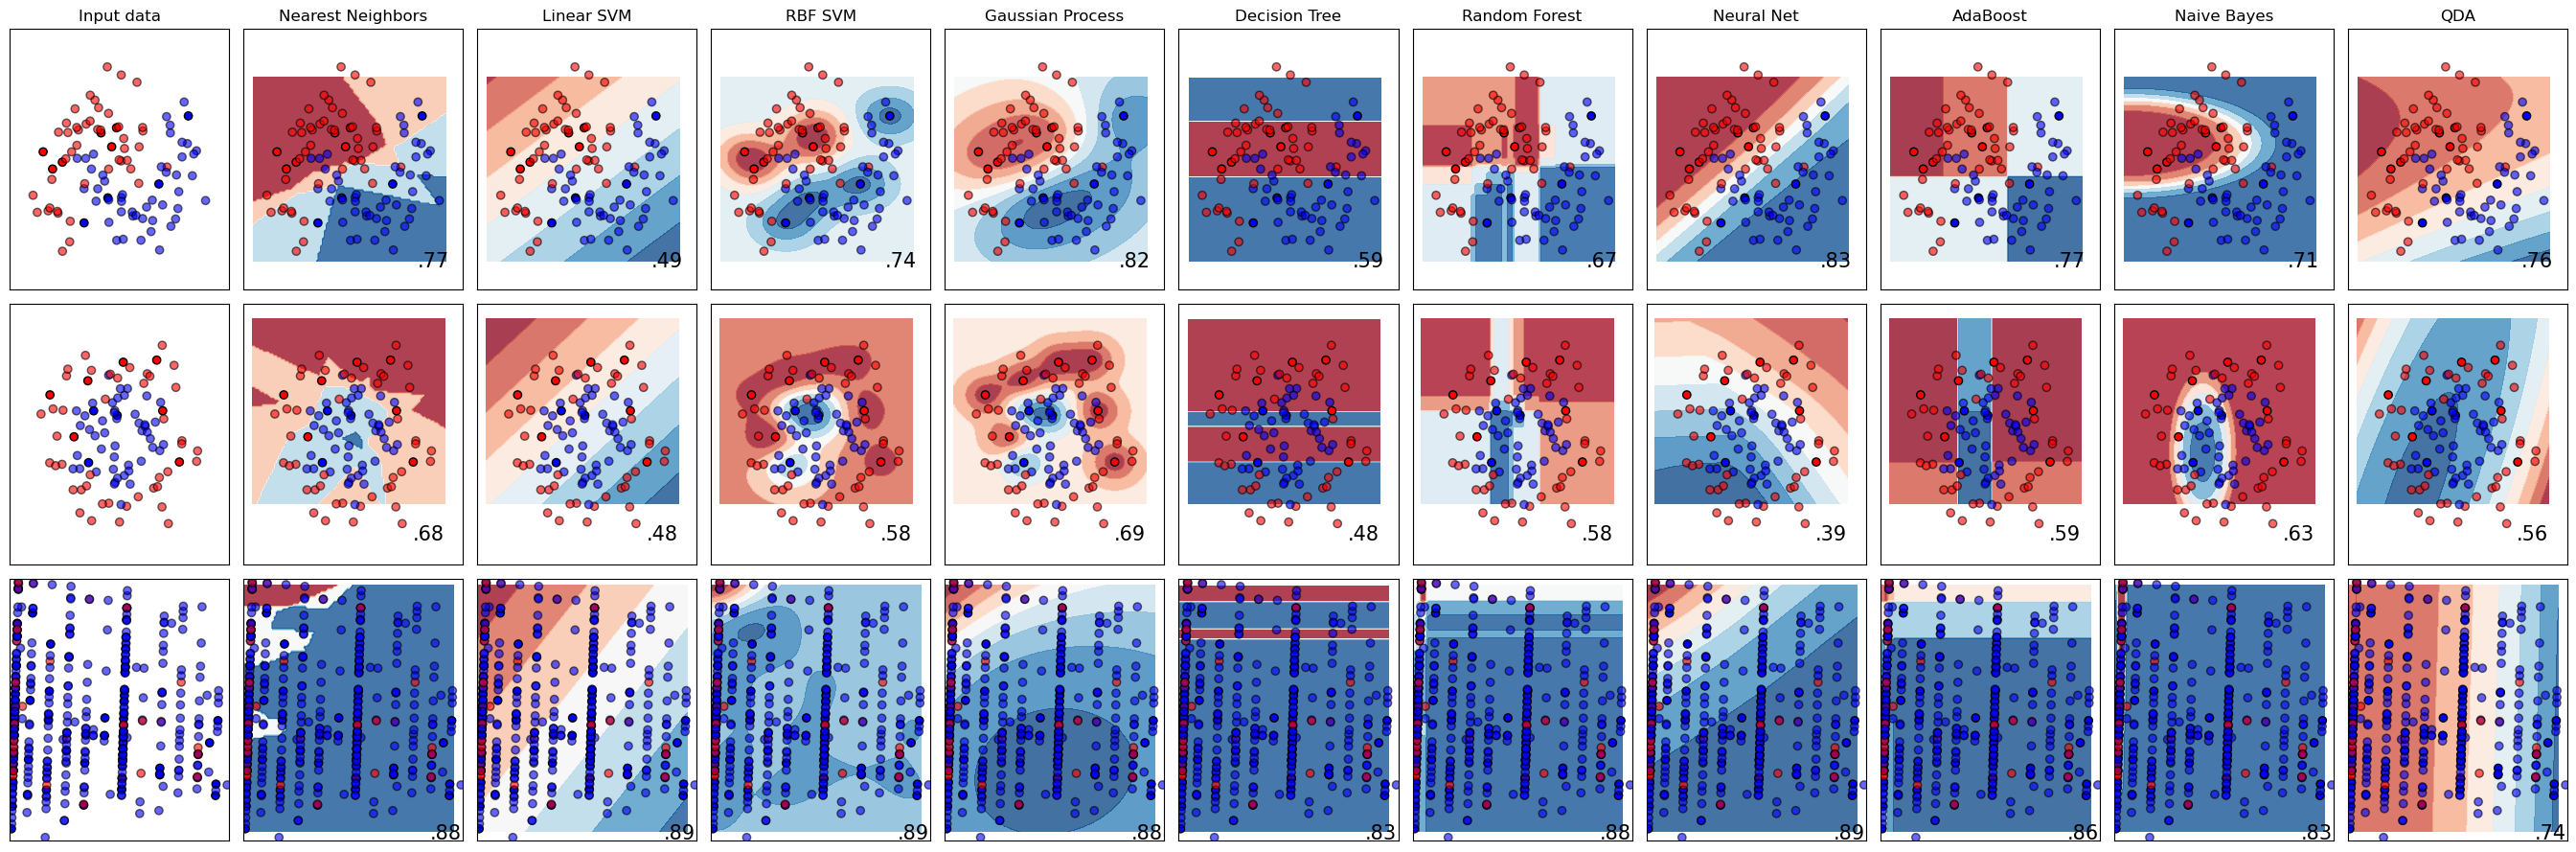

In [27]:


# Assuming `datasets` and `classifiers` are defined and loaded

figure = plt.figure(figsize=(27, 9))
i = 1

for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Reduce dimensions to 2 using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.9, random_state=42
    )

    x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
    y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()


## Below is to show the data for the different areas and their classification report

In [28]:
from sklearn.metrics import classification_report
import pandas as pd

# Initialize an empty DataFrame to store the classification reports
classification_reports = pd.DataFrame()

for i in range(1, 22):
    # Filter data for the current area
    crime_area_df = crime_req_df1[(crime_req_df1['Vict Age'] > 10 ) & (crime_req_df1['Vict Age'] < 55 ) & (crime_req_df1['TIME OCC'] < 100 )  & (crime_req_df1['Vict Sex'].isin(['F']))  & (crime_req_df1['AREA'] == i) & (crime_req_df1['CRIMEBIN'].isin(['VIOLENT','BURGLARY']))]
    col_encode = ['day_of_week','Vict Sex']
    crime_area_df = pd.get_dummies(crime_area_df, columns=col_encode)
    X = crime_area_df.drop(columns=['CRIMEBIN'])
    y = crime_area_df['CRIMEBIN']
    #Split the data into training and test sets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
    # Define the RandomForestClassifier
    rf = RandomForestClassifier()
    # Define a smaller parameter grid
    param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
                }
    subset_size = 20000
    X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

    # Perform GridSearchCV on the subset
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_subset, y_train_subset)

    # Get the best estimator
    best_rf = grid_search.best_estimator_
    # Evaluate the model
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Generate the classification report as a dictionary
    #report_dict = classification_report(y_test, y_pred, output_dict=True)
    #report_dict = {'Area':i,'crime':y,'Accuracy':accuracy,'Precision':precision,'recall':recall,'f1':f1}
    # Convert the dictionary to a DataFrame and transpose it
    #report_df = pd.DataFrame([report_dict])
    # report_df['Accuracy'] = accuracy
    # report_df['Area'] = i
    report_df = pd.DataFrame({
        'AREA': [i],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1]
    })
    # Append the report DataFrame to the main DataFrame
    classification_reports = pd.concat([classification_reports, report_df],ignore_index=True)
    # Reset the index of the final DataFrame
classification_reports.reset_index(inplace=True)





Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\harit\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\harit\anaconda3\Lib\site-packages\

In [29]:
merged_df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'CRIMEBIN', 'year', 'month', 'day_of_week'],
      dtype='object')

In [30]:
areas = merged_df[['AREA','AREA NAME']].drop_duplicates()
areas = areas.sort_values(by='AREA',ascending=True)
areas.reset_index(drop=True,inplace=True)

areas
final_df = pd.merge(classification_reports, areas, on='AREA', how='inner')
final_df

,index,AREA,Accuracy,Precision,Recall,F1,AREA NAME
0,0,1,0.683036,0.648351,0.683036,0.649495,Central
1,1,2,0.762821,0.658232,0.762821,0.682023,Rampart
2,2,3,0.822660,0.854265,0.822660,0.747331,Southwest
3,3,4,0.872340,0.760978,0.872340,0.812863,Hollenbeck
4,4,5,0.834483,0.783024,0.834483,0.771353,Harbor
5,5,6,0.621622,0.577019,0.621622,0.589769,Hollywood
6,6,7,0.687500,0.652597,0.687500,0.662546,Wilshire
7,7,8,0.500000,0.493750,0.500000,0.496410,West LA
8,8,9,0.661538,0.599283,0.661538,0.592167,Van Nuys
9,9,10,0.842105,0.835925,0.842105,0.799776,West Valley


In [31]:
# Display the final DataFrame
print(classification_reports)

    index  AREA  Accuracy  Precision    Recall        F1
0       0     1  0.683036   0.648351  0.683036  0.649495
1       1     2  0.762821   0.658232  0.762821  0.682023
2       2     3  0.822660   0.854265  0.822660  0.747331
3       3     4  0.872340   0.760978  0.872340  0.812863
4       4     5  0.834483   0.783024  0.834483  0.771353
5       5     6  0.621622   0.577019  0.621622  0.589769
6       6     7  0.687500   0.652597  0.687500  0.662546
7       7     8  0.500000   0.493750  0.500000  0.496410
8       8     9  0.661538   0.599283  0.661538  0.592167
9       9    10  0.842105   0.835925  0.842105  0.799776
10     10    11  0.639175   0.581596  0.639175  0.586007
11     11    12  0.888060   0.830054  0.888060  0.848747
12     12    13  0.808743   0.761109  0.808743  0.756691
13     13    14  0.557252   0.542195  0.557252  0.536505
14     14    15  0.696203   0.687877  0.696203  0.614794
15     15    16  0.760417   0.722020  0.760417  0.740045
16     16    17  0.728070   0.6

### Conclusion:
#### As seen in previous comments within this notebook, when all features were included  the accuracy of the model was not to our satisfaction. However, during the process of fine tuining our models the data revealed that area was quite possibly the most important feature in predicting the likelihood of being a victim of crime. Gender and age seemed to be a factor although of less weight and when our model was restricted females within the age bracket of older than 10 and younger than 55 some neighborhoods reached as high as a 90% accuracy according to Random Forest . The findings described above serves as our foundation for granular analysis that follows within the rest of the project. The low accuracy readings served as a touchstone to evaluate features individually to see which features were in fact most important  

In [32]:
#crime_req_df
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

In [33]:
dash_df = merged_df[['year','AREA NAME','CRIMEBIN']]
dash_df

,year,AREA NAME,CRIMEBIN
0,2020,Wilshire,VEHICLE
1,2020,West Valley,VEHICLE
2,2020,Hollenbeck,VEHICLE
3,2020,Southeast,VEHICLE
4,2020,N Hollywood,VEHICLE
...,...,...,...
947678,2022,West Valley,theft
947679,2023,N Hollywood,theft
947680,2023,Devonshire,theft
947681,2024,Devonshire,theft


In [34]:
c_df1 = dash_df.groupby(["year","AREA NAME","CRIMEBIN"]).size().reset_index(name='count')
c_df1.rename(columns = {'AREA NAME': 'AREA'} ,inplace = True)
c_df1

,year,AREA,CRIMEBIN,count
0,2020,77th Street,BURGLARY,1040
1,2020,77th Street,CHILD,217
2,2020,77th Street,Homicide,58
3,2020,77th Street,OTHER,335
4,2020,77th Street,ROBBERY,959
...,...,...,...,...
1149,2024,Wilshire,VANDALISM,320
1150,2024,Wilshire,VEHICLE,378
1151,2024,Wilshire,VIOLENT,487
1152,2024,Wilshire,fraud,50


In [35]:

import dash_table

# Create the Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Crime Data Dashboard"),
    
    html.Div([
        html.Label("Select Year"),
        dcc.Slider(
            id='year-slider',
            min=c_df1['year'].min(),
            max=c_df1['year'].max(),
            value=c_df1['year'].min(),
            marks={str(year): str(year) for year in c_df1['year'].unique()},
            step=None
        )
    ], style={'padding': 20}),
    
    html.Div([
        html.Label("Select Area"),
        dcc.Dropdown(
            id='area-dropdown',
            options=[{'label': area, 'value': area} for area in c_df1['AREA'].unique()],
            value=c_df1['AREA'].unique()[0],
            multi=True
        )
    ], style={'padding': 20}),
    
    dcc.Graph(id='crime-graph'),
    dash_table.DataTable(
        id='crime-table',
        columns=[{"name": i, "id": i} for i in c_df1.columns],
        page_size=10
    )
])

@app.callback(
    [Output('crime-graph', 'figure'),
     Output('crime-table', 'data')],
    [Input('year-slider', 'value'),
     Input('area-dropdown', 'value')]
)
def update_graph(selected_year, selected_areas):
    # Ensure selected_areas is a list
    if isinstance(selected_areas, str):
        selected_areas = [selected_areas]
    
    filtered_df = c_df1[(c_df1['year'] == selected_year) & (c_df1['AREA'].isin(selected_areas))]
    
    fig = px.bar(filtered_df, x='CRIMEBIN', y='count', color='AREA', barmode='group',
                 labels={'CRIMEBIN': 'Type of Crime', 'count': 'Number of Crimes'},
                 title=f"Number of Crimes in {selected_year}")
    # Convert filtered_df to a list of dictionaries for DataTable
    data = filtered_df.to_dict('records')
    
    return fig,data


# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8050)


C:\Users\harit\AppData\Local\Temp\ipykernel_27336\1570097558.py:1: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.